In [92]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score
from numpy import mean,std
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import StackingClassifier

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation

np.random.seed(15)
sns.set(style='dark')

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [93]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

pas_id_train=train['PassengerId'].values
pas_id_test=test['PassengerId'].values

In [94]:
train['Title']=train['Name'].apply(lambda x : x.split(',')[1]).apply(lambda x : x.split('.')[0])

train.drop(['Name','Ticket','PassengerId'], axis=1, inplace=True)

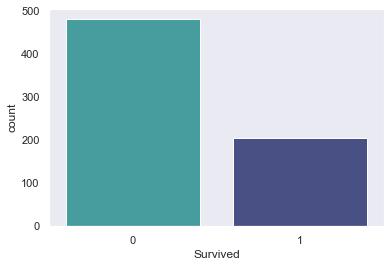

In [95]:
sns.countplot('Survived', data=train.loc[train.Cabin.isna()], palette='mako_r');

In [96]:
train['Cabin'].fillna('H', inplace=True)
train['Cabin']=train['Cabin'].apply(lambda x: x[0])

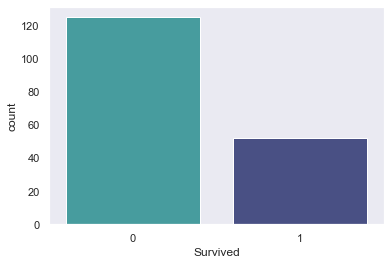

In [97]:
sns.countplot('Survived', data=train.loc[train.Age.isna()], palette='mako_r');

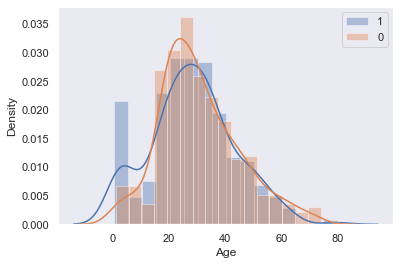

In [98]:
sns.distplot(train.loc[train.Survived==1]['Age'], label='1');
sns.distplot(train.loc[train.Survived==0]['Age'], label='0');
plt.legend();

In [99]:
train['Age'].fillna(train['Age'].median(), inplace=True)

In [100]:
train['Embarked'].fillna(train['Embarked'].mode()[0], inplace=True)

In [101]:
train.isna().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Cabin       0
Embarked    0
Title       0
dtype: int64

In [102]:
train['Family']=train['SibSp']+train['Parch']

train.drop(['SibSp', 'Parch'], axis=1, inplace=True)

In [103]:
print(train.shape)
train.head()

(891, 9)


,Survived,Pclass,Sex,Age,Fare,Cabin,Embarked,Title,Family
0,0,3,male,22.0,7.2500,H,S,Mr,1
1,1,1,female,38.0,71.2833,C,C,Mrs,1
2,1,3,female,26.0,7.9250,H,S,Miss,0
3,1,1,female,35.0,53.1000,C,S,Mrs,1
4,0,3,male,35.0,8.0500,H,S,Mr,0


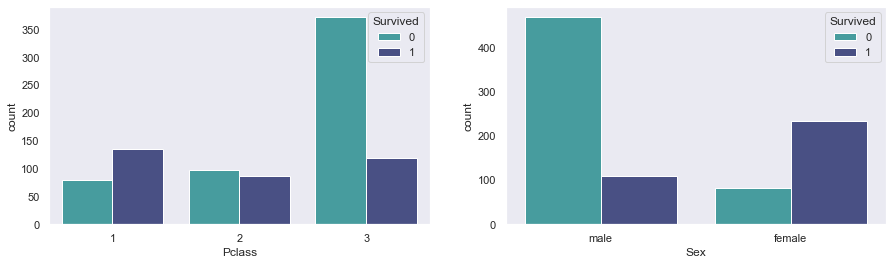

In [104]:
fig, ax = plt.subplots(figsize=(15,4), ncols=2, nrows=1)
sns.countplot(x='Pclass', hue='Survived', data=train, palette='mako_r', ax=ax[0]);
sns.countplot(x='Sex', hue='Survived', data=train, palette='mako_r', ax=ax[1]);

In [105]:
train['Sex'].replace({'male':0, 'female':1}, inplace=True)

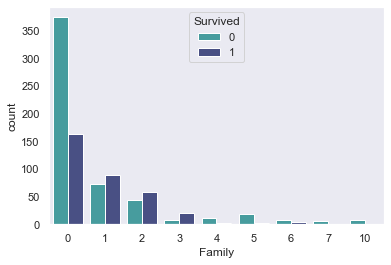

In [106]:
sns.countplot(x='Family', hue='Survived', data=train, palette='mako_r');

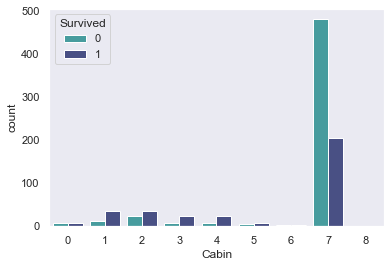

In [107]:
to_replace={'A':0, 'B':1, 'C':2, 'D':3, 'E':4, 'F':5, 'G':6, 'H':7, 'T':8}
train['Cabin'].replace(to_replace, inplace=True)
sns.countplot(x='Cabin', hue='Survived', data=train, palette='mako_r');

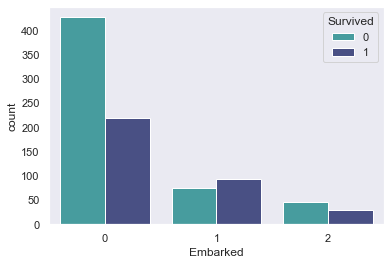

In [108]:
train['Embarked'].replace({'S':0, 'C':1, 'Q':2}, inplace=True)
sns.countplot(x='Embarked', hue='Survived', data=train, palette='mako_r');

In [109]:
to_replace={' Mrs':'Mrs', ' Lady':'Mrs', ' the Countess':'Mrs', ' Mme':'Mrs', ' Ms':'Mrs'}
train['Title'].replace(to_replace, inplace=True)

In [110]:
to_replace={' Mr':'Mr',' Sir':'Mr', ' Don':'Mr', ' Jonkheer':'Mr', ' Capt':'Mr', ' Master':'Mr', ' Major':'Mr', ' Col':'Mr', ' Rev':'Mr', ' Dr':'Mr'}
train['Title'].replace(to_replace, inplace=True)

In [111]:
to_replace={' Miss':'Miss', ' Mlle':'Miss'}
train['Title'].replace(to_replace, inplace=True)

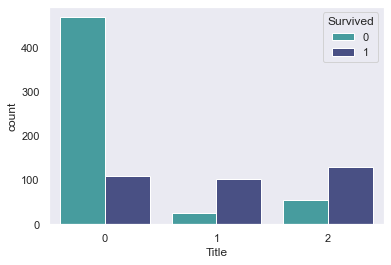

In [112]:
train['Title'].replace({'Mr':0, 'Mrs':1, 'Miss':2}, inplace=True)
sns.countplot(x='Title', hue='Survived', data=train, palette='mako_r');

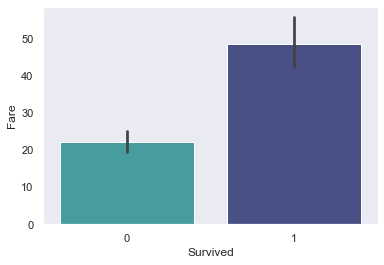

In [113]:
sns.barplot(x='Survived', y='Fare', data=train, palette='mako_r');

In [114]:
rsc=RobustScaler()

min_age=train['Age'].min()
max_age=train['Age'].max()
train['Age']=train['Age'].apply(lambda x : (x-min_age)/(max_age-min_age))

train['Fare']=rsc.fit_transform(train[['Fare', 'Age']])[:,0]

In [115]:
print(train.shape)
train.head()

(891, 9)


,Survived,Pclass,Sex,Age,Fare,Cabin,Embarked,Title,Family
0,0,3,0,0.271174,-0.312011,7,0,0,1
1,1,1,1,0.472229,2.461242,2,1,1,1
2,1,3,1,0.321438,-0.282777,7,0,2,0
3,1,1,1,0.434531,1.673732,2,0,1,1
4,0,3,0,0.434531,-0.277363,7,0,0,0


In [116]:
['Pclass', 'Sex', 'Fare', 'Cabin', 'Title']

['Pclass', 'Sex', 'Fare', 'Cabin', 'Title']

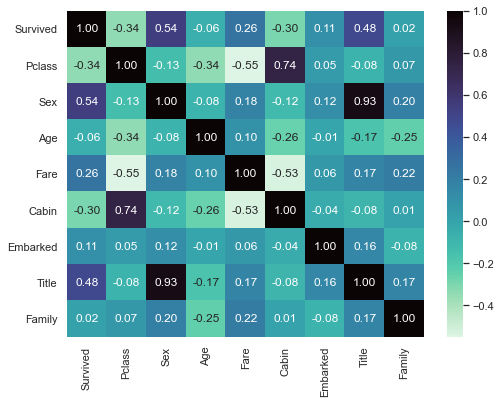

In [117]:
plt.figure(figsize=(8,6))
sns.heatmap(train.corr(), fmt='.2f', annot=True, cmap='mako_r');

In [118]:
def transform(file_dir):
    data = pd.read_csv(file_dir)
    
    data['Title']=data['Name'].apply(lambda x : x.split(',')[1]).apply(lambda x : x.split('.')[0])
    data.drop(['Name','Ticket','PassengerId'], axis=1, inplace=True)
    
    data['Cabin'].fillna('H', inplace=True)
    data['Cabin']=data['Cabin'].apply(lambda x: x[0])
    to_replace={'A':0, 'B':1, 'C':2, 'D':3, 'E':4, 'F':5, 'G':6, 'H':7, 'T':8}
    data['Cabin'].replace(to_replace, inplace=True)
    
    data['Embarked'].fillna(data['Embarked'].mode()[0], inplace=True)
    data['Embarked'].replace({'S':0, 'C':1, 'Q':2}, inplace=True)
    
    data['Family']=data['SibSp']+data['Parch']
    data.drop(['SibSp', 'Parch'], axis=1, inplace=True)
    
    data['Sex'].replace({'male':0, 'female':1}, inplace=True)
    
    to_replace={' Dona':'Mrs', ' Mrs':'Mrs', ' Lady':'Mrs', ' the Countess':'Mrs', ' Mme':'Mrs', ' Ms':'Mrs'}
    data['Title'].replace(to_replace, inplace=True)
    
    to_replace={' Mr':'Mr',' Sir':'Mr', ' Don':'Mr', ' Jonkheer':'Mr', ' Capt':'Mr', ' Master':'Mr', ' Major':'Mr', ' Col':'Mr', ' Rev':'Mr', ' Dr':'Mr'}
    data['Title'].replace(to_replace, inplace=True)
    
    to_replace={' Miss':'Miss', ' Mlle':'Miss'}
    data['Title'].replace(to_replace, inplace=True)
    
    data['Title'].replace({'Mr':0, 'Mrs':1, 'Miss':2}, inplace=True)

    rsc=RobustScaler()
    data['Age'].fillna(data['Age'].mean(), inplace=True)
    min_age=data['Age'].min()
    max_age=data['Age'].max()
    data['Age']=data['Age'].apply(lambda x : (x-min_age)/(max_age-min_age))

    data['Fare'].fillna(data['Fare'].mean(), inplace=True)
    data['Fare']=rsc.fit_transform(data[['Fare', 'Age']])[:,0]
    
    return data

In [119]:
train = transform('train.csv')[['Pclass', 'Sex', 'Fare', 'Cabin', 'Title', 'Survived']]
test = transform('test.csv')[['Pclass', 'Sex', 'Fare', 'Cabin', 'Title']]

In [120]:
train.head()

,Pclass,Sex,Fare,Cabin,Title,Survived
0,3,0,-0.312011,7,0,0
1,1,1,2.461242,2,1,1
2,3,1,-0.282777,7,2,1
3,1,1,1.673732,2,1,1
4,3,0,-0.277363,7,0,0


In [121]:
X=train.drop('Survived', axis=1)
y=train['Survived']

In [122]:
model = Sequential()
model.add(Dense(256, activation='relu', input_shape = X.shape[1:]))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss="binary_crossentropy",
              optimizer="sgd",
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 256)               1536      
_________________________________________________________________
dense_15 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_17 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_5 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 16)               

In [123]:
history=model.fit(X, y, batch_size=32, validation_split=0.25, epochs=200)

Epoch 1/200
21/21 [==============================] - 2s 22ms/step - loss: 0.7301 - accuracy: 0.4154 - val_loss: 0.6731 - val_accuracy: 0.6682
Epoch 2/200
21/21 [==============================] - 0s 6ms/step - loss: 0.6861 - accuracy: 0.5529 - val_loss: 0.6591 - val_accuracy: 0.6726
Epoch 3/200
21/21 [==============================] - 0s 7ms/step - loss: 0.6801 - accuracy: 0.5692 - val_loss: 0.6538 - val_accuracy: 0.6682
Epoch 4/200
21/21 [==============================] - 0s 5ms/step - loss: 0.6677 - accuracy: 0.6053 - val_loss: 0.6494 - val_accuracy: 0.6682
Epoch 5/200
21/21 [==============================] - 0s 6ms/step - loss: 0.6638 - accuracy: 0.6077 - val_loss: 0.6422 - val_accuracy: 0.6682
Epoch 6/200
21/21 [==============================] - 0s 5ms/step - loss: 0.6724 - accuracy: 0.5646 - val_loss: 0.6343 - val_accuracy: 0.6682
Epoch 7/200
21/21 [==============================] - 0s 6ms/step - loss: 0.6438 - accuracy: 0.6207 - val_loss: 0.6248 - val_accuracy: 0.6682
Epoch 8/200


Epoch 59/200
21/21 [==============================] - 0s 6ms/step - loss: 0.4904 - accuracy: 0.7982 - val_loss: 0.4964 - val_accuracy: 0.7848
Epoch 60/200
21/21 [==============================] - 0s 6ms/step - loss: 0.4790 - accuracy: 0.8094 - val_loss: 0.4986 - val_accuracy: 0.7892
Epoch 61/200
21/21 [==============================] - 0s 6ms/step - loss: 0.5168 - accuracy: 0.7730 - val_loss: 0.4974 - val_accuracy: 0.7758
Epoch 62/200
21/21 [==============================] - 0s 7ms/step - loss: 0.5266 - accuracy: 0.7810 - val_loss: 0.4981 - val_accuracy: 0.7848
Epoch 63/200
21/21 [==============================] - 0s 5ms/step - loss: 0.5198 - accuracy: 0.7745 - val_loss: 0.4974 - val_accuracy: 0.7848
Epoch 64/200
21/21 [==============================] - 0s 5ms/step - loss: 0.5256 - accuracy: 0.7652 - val_loss: 0.4961 - val_accuracy: 0.7848
Epoch 65/200
21/21 [==============================] - 0s 6ms/step - loss: 0.5055 - accuracy: 0.7883 - val_loss: 0.4955 - val_accuracy: 0.7803
Epoch 

21/21 [==============================] - 0s 5ms/step - loss: 0.4797 - accuracy: 0.7929 - val_loss: 0.4759 - val_accuracy: 0.7848
Epoch 117/200
21/21 [==============================] - 0s 5ms/step - loss: 0.4901 - accuracy: 0.7768 - val_loss: 0.4762 - val_accuracy: 0.7848
Epoch 118/200
21/21 [==============================] - 0s 6ms/step - loss: 0.5104 - accuracy: 0.7594 - val_loss: 0.4768 - val_accuracy: 0.7848
Epoch 119/200
21/21 [==============================] - 0s 6ms/step - loss: 0.4519 - accuracy: 0.8037 - val_loss: 0.4758 - val_accuracy: 0.7848
Epoch 120/200
21/21 [==============================] - 0s 5ms/step - loss: 0.4980 - accuracy: 0.7715 - val_loss: 0.4729 - val_accuracy: 0.7848
Epoch 121/200
21/21 [==============================] - 0s 6ms/step - loss: 0.4982 - accuracy: 0.7809 - val_loss: 0.4723 - val_accuracy: 0.7848
Epoch 122/200
21/21 [==============================] - 0s 6ms/step - loss: 0.5216 - accuracy: 0.7682 - val_loss: 0.4725 - val_accuracy: 0.7848
Epoch 123/200

21/21 [==============================] - 0s 5ms/step - loss: 0.4768 - accuracy: 0.7944 - val_loss: 0.4480 - val_accuracy: 0.8027
Epoch 174/200
21/21 [==============================] - 0s 5ms/step - loss: 0.4254 - accuracy: 0.8140 - val_loss: 0.4563 - val_accuracy: 0.8027
Epoch 175/200
21/21 [==============================] - 0s 6ms/step - loss: 0.4624 - accuracy: 0.8167 - val_loss: 0.4523 - val_accuracy: 0.7982
Epoch 176/200
21/21 [==============================] - 0s 5ms/step - loss: 0.4744 - accuracy: 0.7721 - val_loss: 0.4548 - val_accuracy: 0.8027
Epoch 177/200
21/21 [==============================] - 0s 6ms/step - loss: 0.4759 - accuracy: 0.7806 - val_loss: 0.4459 - val_accuracy: 0.7982
Epoch 178/200
21/21 [==============================] - 0s 5ms/step - loss: 0.4537 - accuracy: 0.8059 - val_loss: 0.4496 - val_accuracy: 0.8027
Epoch 179/200
21/21 [==============================] - 0s 5ms/step - loss: 0.4373 - accuracy: 0.8281 - val_loss: 0.4448 - val_accuracy: 0.8072
Epoch 180/200

In [124]:
# Save the model
model.save("titanic.model")
tf.keras.models.save_model(model, "titanic.h5")

INFO:tensorflow:Assets written to: titanic.model\assets


In [125]:
_, train_accuracy = model.evaluate(X, y, verbose=0)
print('Train Accuracy : {:.0f}%'.format(train_accuracy*100))

Train Accuracy : 80%


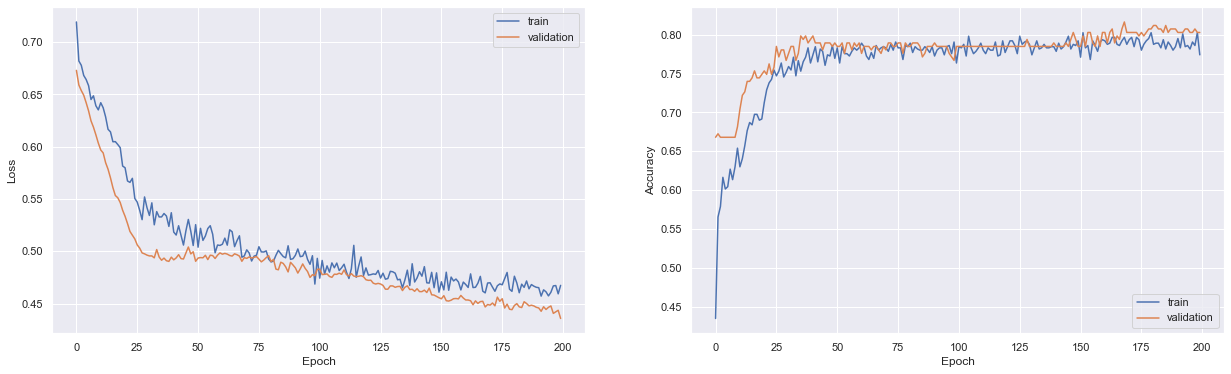

In [126]:
plt.figure(figsize=(21,6))

plt.subplot(121)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label = 'validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True);
plt.legend();

plt.subplot(122)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label = 'validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True);
plt.legend();

In [127]:
def predict_submit_MPL():
    test_predictions = model.predict(test.values)
    test_labels=np.rint(test_predictions)
    test_labels=test_labels.reshape(test_labels.shape[0])
    
    submission = pd.DataFrame()
    submission['PassengerId']=pas_id_test
    submission['Survived']=np.int16(test_labels)
    
    submission.to_csv('Sub5.csv', index=False)

In [128]:
# define the base models
level0 = list()
level0.append(('rg', RidgeClassifier()))
level0.append(('knn', KNeighborsClassifier()))
level0.append(('dt', DecisionTreeClassifier()))
level0.append(('et', ExtraTreeClassifier()))
level0.append(('rf', RandomForestClassifier()))
level0.append(('gb', GradientBoostingClassifier()))
level0.append(('xgb', XGBClassifier()))
level0.append(('svm', SVC()))
level0.append(('bayes', GaussianNB()))

# define meta learner model
level1 = LogisticRegression()
# define the stacking ensemble
sc_model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)

In [129]:
models = dict()
models['rg'] = RidgeClassifier()
models['knn'] = KNeighborsClassifier()
models['dtc'] = DecisionTreeClassifier()
models['xgb']= XGBClassifier()
models['et']= ExtraTreeClassifier()
models['rf']= RandomForestClassifier()
models['gb'] = GradientBoostingClassifier()
models['xgb']= XGBClassifier()
models['svm'] = SVC()
models['gnb'] = GaussianNB()
models['stacking'] = sc_model

In [130]:
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    results.append(scores)
    names.append(name)
    print('>> %s : %.3f (%.3f)' % (name, mean(scores), std(scores)))

>> rg : 0.785 (0.043)
>> knn : 0.799 (0.041)
>> dtc : 0.801 (0.041)
>> xgb : 0.810 (0.038)
>> et : 0.790 (0.042)
>> rf : 0.789 (0.039)
>> gb : 0.822 (0.034)
>> svm : 0.785 (0.044)
>> gnb : 0.766 (0.042)
>> stacking : 0.817 (0.033)


In [135]:
test_predictions = sc_model.fit(X,y).predict(test)
test_labels=np.rint(test_predictions)
test_labels=test_labels.reshape(test_labels.shape[0])

submission = pd.DataFrame()
submission['PassengerId']=pas_id_test
submission['Survived']=np.int16(test_labels)

submission.to_csv('Sub_SC.csv', index=False)

AttributeError: 'StackingClassifier' object has no attribute 'estimator'

In [133]:
sc_model.predict_

Object `sc_model.predict` not found.
